<a href="https://colab.research.google.com/github/ni414/notebook/blob/master/lstm_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
from math import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense,LSTM,Bidirectional,GRU
from keras.layers import Flatten, Dropout
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [60]:
data = np.load('/content/drive/MyDrive/rainfall_data.npy')
data = np.where(data<0,0,data)
one_grid = data[:,:,64,74]
one_grid=one_grid.reshape([one_grid.shape[0] * one_grid.shape[1], 1])
one_grid = preprocessing.normalize(one_grid)

region = data[:, :, 63:66, 73:76]
region = region.reshape([region.shape[0] * region.shape[1], 9])
region=preprocessing.normalize(region)

In [61]:
n = region.shape[0]
train = region[0:int(n*0.8)]
#val_data = region[int(n*0.7):int(n*0.9)]
test = region[int(n*0.8):]

In [62]:
test.shape

(276, 9)

In [63]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 36
X_train, y_train = create_dataset(train,LOOK_BACK)
X_test, y_test = create_dataset(test,LOOK_BACK)
#X_val, y_val = create_dataset(val_data,LOOK_BACK)
# Print data shape
print("X.shape: ", X_train.shape, X_test.shape)
print("y.shape: ", y_train.shape, y_test.shape)

X.shape:  (1068, 36, 9) (240, 36, 9)
y.shape:  (1068, 9) (240, 9)


In [64]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [65]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [66]:
max_epochs=100
def fit_model(model):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = max_epochs,  
                        validation_split= 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop],verbose=0)
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

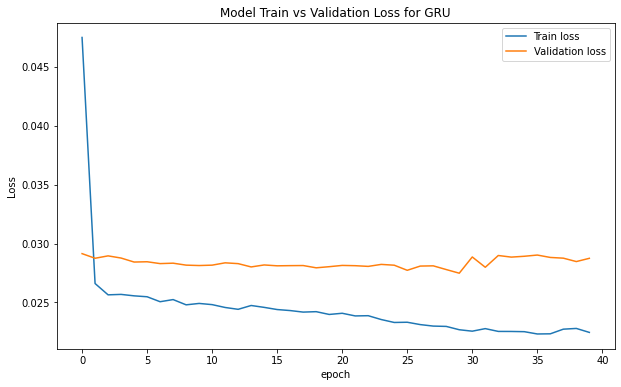

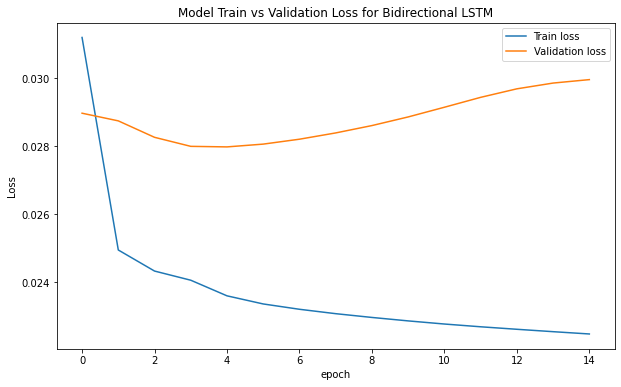

In [67]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [68]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

In [69]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions-actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 0.1264
Root Mean Square Error: 0.1675

Bidirectiona LSTM:
Mean Absolute Error: 0.1333
Root Mean Square Error: 0.1723



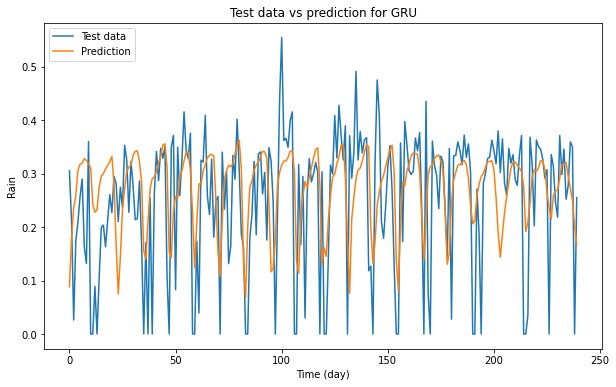

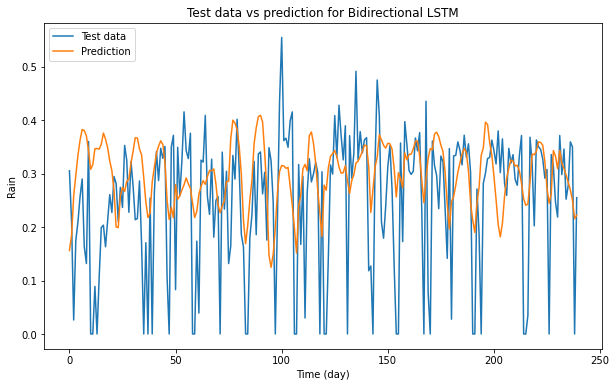

In [70]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test[:,4]), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Rain')
 
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [71]:
model_bilstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 36, 128)           37888     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 136,833
Trainable params: 136,833
Non-trainable params: 0
_________________________________________________________________


In [72]:
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 36, 64)            14400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 39,425
Trainable params: 39,425
Non-trainable params: 0
_________________________________________________________________
